# Variance of fit parameters

We use the bootstrap and the jackknife to compute the uncertainties of a non-linear least-squares fit. The bootstrap is generally superior to the jackknife, which we will also see here. We use `scipy.optimize.curve_fit` to perform the fit, which also estimates the parameter uncertainties with asymptotic theory. For reference, we also doing a Monte-Carlo simulation of the experiment with a large number of tries, to have a reference for the parameter uncertainties.

In this case, the asymptotic theory estimate is very accurate, while the bootstrap and the jackknife estimates are similar and off. The accuracy of the non-parametric methods improves with the sample size.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from resample import bootstrap, jackknife

rng = np.random.default_rng(1)

# generate some random data, each y value scatters randomly
x = np.linspace(0, 1, 100)
y = 1 + 10 * x ** 2
ye = 0.5 + x
y += rng.normal(0, ye)

In [2]:
def model(x, a, b, c):
    return a + b * x + c * x ** 2

def fit(x, y, ye):
    return curve_fit(model, x, y, sigma=ye, absolute_sigma=True)

# fit original data and compute covariance estimate from asymptotic theory
par, cov = fit(x, y, ye)

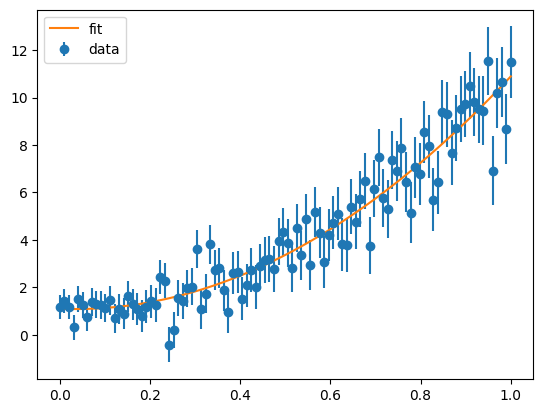

In [3]:
plt.errorbar(x, y, ye, fmt="o", label="data")
xm = np.linspace(np.min(x), np.max(x), 1000)
plt.plot(xm, model(xm, *par), label="fit")
plt.legend();

In [4]:
# now only return fit parameters
def fit2(x, y, ye):
    return fit(x, y, ye)[0]

# jackknife and bootstrap
jvar = jackknife.variance(fit2, x, y, ye)
bvar = bootstrap.variance(fit2, x, y, ye, size=1000, random_state=1)

# Monte-Carlo simulation for reference
mvar = []
for itry in range(1000):
    y2 = 1 + 10 * x ** 2 + rng.normal(0, ye)
    mvar.append(fit2(x, y2, ye))
mvar = np.var(mvar, axis=0)

for n, p, e, ej, eb, em in zip("abc", par,
                               np.diag(cov) ** 0.5,
                               jvar ** 0.5,
                               bvar ** 0.5,
                               mvar ** 0.5):
    print(f"{n} = {p:5.2f} +/- {e:1.2f} "
          f"jackknife={ej:1.2f} "
          f"bootstrap={eb:1.2f} "
          f"MC={em:1.2f}")

a =  1.10 +/- 0.18 jackknife=0.13 bootstrap=0.13 MC=0.18
b = -0.72 +/- 1.09 jackknife=0.93 bootstrap=0.88 MC=1.04
c = 10.52 +/- 1.22 jackknife=1.11 bootstrap=1.05 MC=1.19
